In [149]:
import torch
from torchvision import models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from prettytable import PrettyTable
import pandas as pd


In [171]:
class CNNModel(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv_layer = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(16 * 32 * 32, 128),
            # nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.ELU() # enforce positive output
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv_layer(x)
        # Flatten
        x = torch.flatten(x, start_dim=1)
        # Fully connected layers
        x = self.fc_layer(x)
        return x
    
class CNNModel2(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(CNNModel2, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(2048, output_dim)
        self.model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        nn.init.kaiming_normal_(self.model.conv1.weight, mode='fan_out', nonlinearity='relu')

        # # Freeze all layers initially
        # for param in self.model.parameters():
        #     param.requires_grad = False

        # # Unfreeze the first layer (initial conv layer)
        # for param in self.model.conv1.parameters():
        #     param.requires_grad = True

        # # Unfreeze the last fully connected layer
        # for param in self.model.fc.parameters():
        #     param.requires_grad = True

    def forward(self, x):
        return self.model(x)

class ImageDataset(Dataset):
    def __init__(self, data, targets, transform=None,target_transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

params_dict = {
		'macrophage_max_recruitment_rate': [0,8e-9],
		'macrophage_recruitment_min_signal': [0,0.2],
		'macrophage_recruitment_saturation_signal': [0,0.6],
		'DC_max_recruitment_rate': [0,4e-9],
		'DC_recruitment_min_signal': [0,0.2],
		'DC_recruitment_saturation_signal': [0,0.6],
		'DC_leave_rate': [0,0.4],
		'Th1_decay': [0,2.8e-6],
		'T_Cell_Recruitment': [0,2.2e-4],
		'DM_decay': [0,7e-4]
}

data_layers = [
    'activated_TNF_secretion_rate',
    'activated_immune_cell',
    'cell_type_CD4_Tcell',
    'cell_type_CD8_Tcell',
    'cell_type_DC',
    'cell_type_cancer_cell',
    'cell_type_lung_cell',
    'cell_type_macrophage',
    'current_phase_G0G1_phase',
    'current_phase_G2_phase',
    'current_phase_M_phaseapoptotic',
    'current_phase_S_phase',
    'debris_secretion_rate',
    'nuclear_volume',
    'sensitivity_to_TNF_chemotaxis',
    'sensitivity_to_debris_chemotaxis',
    'total_volume',
    'TNF',
    'debris'
]

param_ranges = torch.tensor([x[1] - x[0] for x in params_dict.values()])

In [172]:
param_ranges

tensor([8.0000e-09, 2.0000e-01, 6.0000e-01, 4.0000e-09, 2.0000e-01, 6.0000e-01,
        4.0000e-01, 2.8000e-06, 2.2000e-04, 7.0000e-04])

In [173]:
data = np.load('../dl_data/100_data.npy')
Theta = np.load('../dl_data/theta.npy')
data = np.transpose(data, (0, 3, 1, 2))
L, H, W = data.shape[1], data.shape[2], data.shape[3]
B = data.shape[0]
T = Theta.shape[1]

data = torch.tensor(data, dtype=torch.float32)
Theta = torch.tensor(Theta, dtype=torch.float32)

# Define parameters
input_channels = L  # Number of channels in images
output_dim = T      # Number of outputs in Theta

In [197]:
# Instantiate the model
# model = CNNModel(input_channels=input_channels, output_dim=output_dim)
model = CNNModel(input_channels=input_channels, output_dim=output_dim)


# Define loss and optimizer
criterion = nn.MSELoss()  # Use a suitable loss function, e.g., MSE for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

CNNModel(
  (conv_layer): Sequential(
    (0): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=16384, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): ELU(alpha=1.0)
  )
)

In [198]:
def fw_hook(module, input, output):
    print(f"Shape of output from {module} is {output.shape}.")


# Any tensor created within this torch.device context manager will be
# on the meta device.
with torch.device("meta"):
    net = CNNModel(input_channels=input_channels, output_dim=output_dim)
    inp = torch.randn((256, L, H, W))

for name, layer in net.named_modules():
    layer.register_forward_hook(fw_hook)

out = net(inp)

Shape of output from Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) is torch.Size([256, 32, 128, 128]).
Shape of output from BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) is torch.Size([256, 32, 128, 128]).
Shape of output from ReLU() is torch.Size([256, 32, 128, 128]).
Shape of output from MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is torch.Size([256, 32, 64, 64]).
Shape of output from Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) is torch.Size([256, 16, 64, 64]).
Shape of output from BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) is torch.Size([256, 16, 64, 64]).
Shape of output from ReLU() is torch.Size([256, 16, 64, 64]).
Shape of output from MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is torch.Size([256, 16, 32, 32]).
Shape of output from Sequential(
  (0): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=

In [199]:
transform = transforms.Compose([
    # transforms.ToTensor(),  # Convert image to tensor
	# transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize to range [-1, 1]
    transforms.RandomRotation(degrees=(0,360)),  # Rotate randomly within ±30 degrees
    transforms.RandomHorizontalFlip(p=0.75),  # Flip horizontally with 50% probability
    transforms.RandomVerticalFlip(p=0.75),  # Flip vertically with 50% probability
    transforms.RandomResizedCrop(size=(128,128), scale=(0.5, 1.0),ratio=(3/4,4/3),antialias=True),  # Random crop and resize
])

dataset = ImageDataset(data, Theta, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify the split
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 204
Validation dataset size: 52


In [200]:
# Training loop (simplified)
validation_loss = []
training_loss = []
num_epochs = 200
param_ranges = param_ranges.to(device)

early_stopping = EarlyStopping(patience=5, min_delta=0.0)

for epoch in range(num_epochs):
    train_loss = 0.0
    num_batches = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        model.train()
        for input, target in tepoch:
            optimizer.zero_grad()
            input = input.to(device)
            target = target.to(device)

            target = target / param_ranges
            # print(target[0])
            outputs = model(input)

            loss = criterion(outputs, target) 
            loss.backward()  # Backward pass
            optimizer.step()

            # Accumulate metrics
            train_loss += loss.item()
            num_batches += 1
            
            # Update tqdm bar
            tepoch.set_postfix(batch_loss=loss.item())
        training_loss.append(train_loss / num_batches)

    # Validation loop
    val_loss = 0.0
    num_batches = 0
    model.eval()
    with torch.no_grad():
        for input, target in val_loader:
            input = input.to(device)
            target = target.to(device)
            target = target / param_ranges

            output = model(input)

            loss = criterion(output, target)
            val_loss += loss.item()
            num_batches += 1
    validation_loss.append(val_loss / num_batches)
    # Epoch-level metrics
    avg_val_loss = val_loss / num_batches
    print(f"Epoch {epoch+1} completed. Average  Val Loss: {avg_val_loss:.4f}")
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

100%|██████████| 7/7 [00:00<00:00,  8.02batch/s, batch_loss=0.364]


Epoch 1 completed. Average  Val Loss: 2.0398


100%|██████████| 7/7 [00:00<00:00, 11.34batch/s, batch_loss=0.204]


Epoch 2 completed. Average  Val Loss: 1.3042


100%|██████████| 7/7 [00:00<00:00, 11.34batch/s, batch_loss=0.174]


Epoch 3 completed. Average  Val Loss: 0.4256


100%|██████████| 7/7 [00:00<00:00, 10.83batch/s, batch_loss=0.102]


Epoch 4 completed. Average  Val Loss: 0.1844


100%|██████████| 7/7 [00:00<00:00, 11.60batch/s, batch_loss=0.103]


Epoch 5 completed. Average  Val Loss: 0.1475


100%|██████████| 7/7 [00:00<00:00, 11.67batch/s, batch_loss=0.139]


Epoch 6 completed. Average  Val Loss: 0.1685


100%|██████████| 7/7 [00:00<00:00, 11.43batch/s, batch_loss=0.105]


Epoch 7 completed. Average  Val Loss: 0.1551


100%|██████████| 7/7 [00:00<00:00, 11.63batch/s, batch_loss=0.122]


Epoch 8 completed. Average  Val Loss: 0.1160


100%|██████████| 7/7 [00:00<00:00, 11.07batch/s, batch_loss=0.109]


Epoch 9 completed. Average  Val Loss: 0.1090


100%|██████████| 7/7 [00:00<00:00, 11.64batch/s, batch_loss=0.0969]


Epoch 10 completed. Average  Val Loss: 0.1081


100%|██████████| 7/7 [00:00<00:00, 11.62batch/s, batch_loss=0.104] 


Epoch 11 completed. Average  Val Loss: 0.0993


100%|██████████| 7/7 [00:00<00:00, 11.56batch/s, batch_loss=0.104] 


Epoch 12 completed. Average  Val Loss: 0.0924


100%|██████████| 7/7 [00:00<00:00, 10.97batch/s, batch_loss=0.127] 


Epoch 13 completed. Average  Val Loss: 0.1048


100%|██████████| 7/7 [00:00<00:00, 11.36batch/s, batch_loss=0.125] 


Epoch 14 completed. Average  Val Loss: 0.0952


100%|██████████| 7/7 [00:00<00:00, 11.55batch/s, batch_loss=0.116] 


Epoch 15 completed. Average  Val Loss: 0.1018


100%|██████████| 7/7 [00:00<00:00, 11.41batch/s, batch_loss=0.119] 


Epoch 16 completed. Average  Val Loss: 0.0981


100%|██████████| 7/7 [00:00<00:00, 10.98batch/s, batch_loss=0.0871]


Epoch 17 completed. Average  Val Loss: 0.0907


100%|██████████| 7/7 [00:00<00:00, 11.13batch/s, batch_loss=0.1]   


Epoch 18 completed. Average  Val Loss: 0.0981


100%|██████████| 7/7 [00:00<00:00, 11.45batch/s, batch_loss=0.0844]


Epoch 19 completed. Average  Val Loss: 0.0962


100%|██████████| 7/7 [00:00<00:00, 11.25batch/s, batch_loss=0.0935]


Epoch 20 completed. Average  Val Loss: 0.0891


100%|██████████| 7/7 [00:00<00:00, 11.26batch/s, batch_loss=0.0881]


Epoch 21 completed. Average  Val Loss: 0.0842


100%|██████████| 7/7 [00:00<00:00, 11.36batch/s, batch_loss=0.0775]


Epoch 22 completed. Average  Val Loss: 0.0922


100%|██████████| 7/7 [00:00<00:00, 11.36batch/s, batch_loss=0.0799]


Epoch 23 completed. Average  Val Loss: 0.1099


100%|██████████| 7/7 [00:00<00:00, 11.52batch/s, batch_loss=0.102] 


Epoch 24 completed. Average  Val Loss: 0.0969


100%|██████████| 7/7 [00:00<00:00, 11.37batch/s, batch_loss=0.1]   


Epoch 25 completed. Average  Val Loss: 0.0993


100%|██████████| 7/7 [00:00<00:00, 11.25batch/s, batch_loss=0.103] 


Epoch 26 completed. Average  Val Loss: 0.0900
Early stopping triggered!


In [201]:
model.eval()

# Prepare to store predictions and actual values
predictions_list = []
actuals_list = []
param_ranges = param_ranges.to(device)
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        loss = criterion(outputs, targets) 
        # Denormalize the outputs
        predictions = outputs * param_ranges
        print(loss.item())
        # print(predictions)
        # Collect predictions and actuals
        predictions_list.extend(predictions.tolist())  # List of vectors
        actuals_list.extend(targets.tolist())  # List of vectors

0.24587570130825043
0.24496187269687653


In [202]:
# Pretty print results in a stacked format
nms = list(params_dict.keys())
table = PrettyTable(["Index", "Type"] + nms)
percent_diffs = []
for idx, (pred_vec, actual_vec) in enumerate(zip(predictions_list, actuals_list)):
    # Format predictions and actuals as strings
    # percent difference compared to actual
    pred_vec = np.array(pred_vec)
    actual_vec = np.array(actual_vec)
    percent_diff = np.abs((pred_vec - actual_vec) / actual_vec) * 100
    percent_diffs.append(percent_diff)
    # Add rows for predictions and actuals
    table.add_row([idx, "Prediction"] + [f"{x:.2e}" for x in pred_vec])
    table.add_row([idx, "Actual"] + [f"{x:.2e}" for x in actual_vec])
    table.add_row([idx, "Percent Difference"] + [f"{x:.2f}%" for x in percent_diff])
    table.add_row(["-"*5, "-"*9] + ["-"*10 for _ in range(len(nms))])  # Separator for better readability

meds = np.median(np.array(percent_diffs),axis=0)
table.add_row(["Median", "Percent Difference"] + [f"{x:.2f}%" for x in meds])
print(table)

+--------+--------------------+---------------------------------+-----------------------------------+------------------------------------------+-------------------------+---------------------------+----------------------------------+---------------+------------+--------------------+------------+
| Index  |        Type        | macrophage_max_recruitment_rate | macrophage_recruitment_min_signal | macrophage_recruitment_saturation_signal | DC_max_recruitment_rate | DC_recruitment_min_signal | DC_recruitment_saturation_signal | DC_leave_rate | Th1_decay  | T_Cell_Recruitment |  DM_decay  |
+--------+--------------------+---------------------------------+-----------------------------------+------------------------------------------+-------------------------+---------------------------+----------------------------------+---------------+------------+--------------------+------------+
|   0    |     Prediction     |             3.40e-09            |              5.96e-02             |        

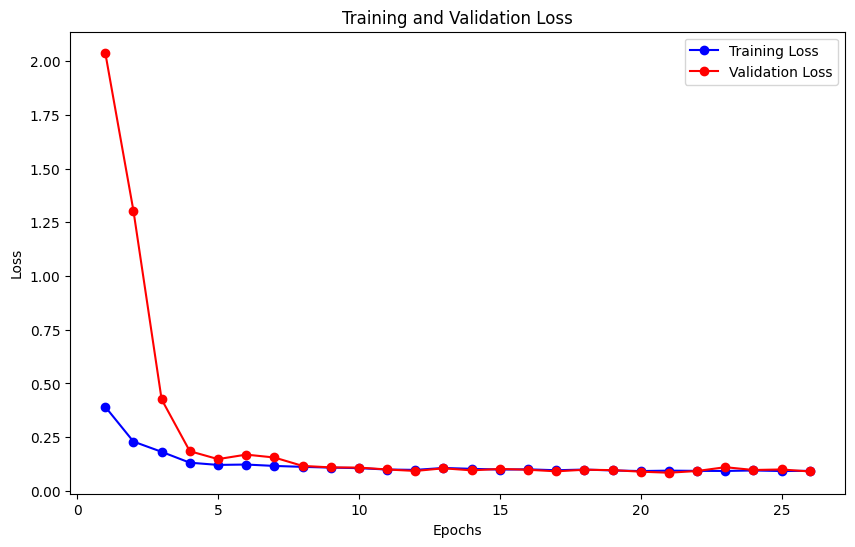

In [203]:
import matplotlib.pyplot as plt

# Assuming you have training and validation losses recorded
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

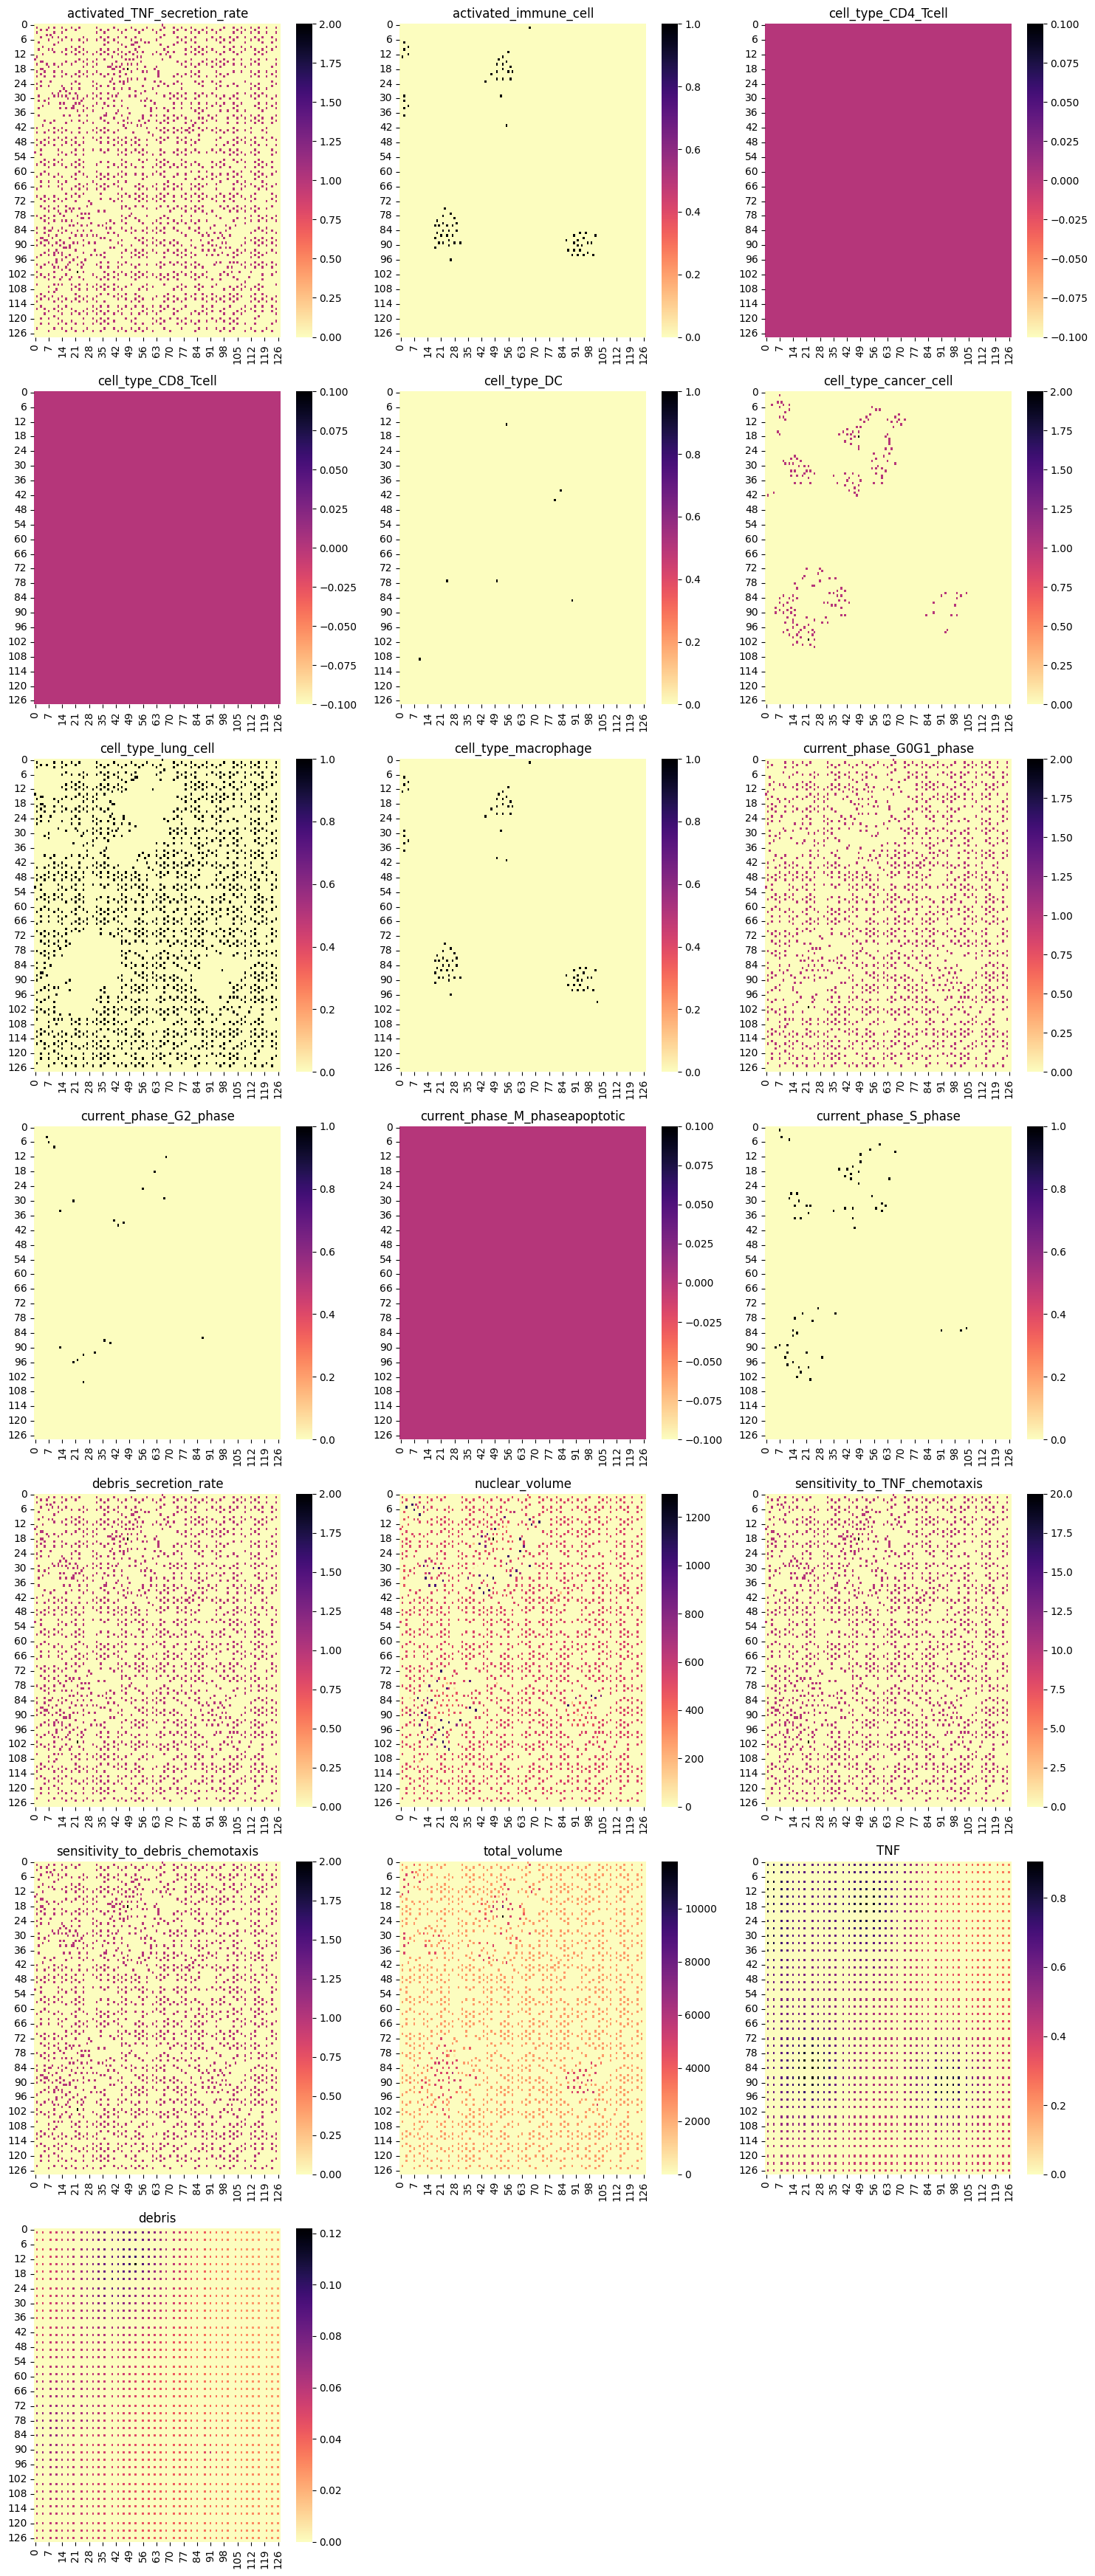

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example 128x128x6 NumPy array (replace with your actual data)
# idx = range(0, 6)
# data = cell_tens[:, :, idx]
# nms = np.array(varnames)[idx]
tens = data[1]
nms = data_layers

vmin = 0
# Define the number of rows and columns for the facet grid
n_slices = tens.shape[0]
n_cols = 3  # Adjust based on your preference
n_rows = (n_slices + n_cols - 1) // n_cols  # Calculate rows to fit all slices

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration (handle case where there's only one row)
axes = axes.flatten()

# Iterate through slices and plot
for i in range(n_slices):
    sns.heatmap(tens[i, :, :], ax=axes[i], cbar=True, cmap="magma_r", vmin=vmin)
    axes[i].set_title(nms[i])

# Hide any unused subplots
for j in range(n_slices, len(axes)):
    axes[j].axis('off')

# Adjust layout for readability
plt.tight_layout()
plt.show()

## NN diagnostics

In [204]:
import weightwatcher as ww

watcher = ww.WeightWatcher(model=model)
details = watcher.analyze()
summary = watcher.get_summary(details)

In [205]:
summary

{'log_norm': 0.962275542505471,
 'alpha': 5.552705686298221,
 'alpha_weighted': -3.134674116485847,
 'log_alpha_norm': -2.697291218018808,
 'log_spectral_norm': -0.34417930528007584,
 'stable_rank': 26.95644548847408}

In [206]:
with pd.option_context('display.max_columns', None):
    print(details)

   layer_id    name         D    M      N           Q     alpha  \
0         2  Conv2d  0.110281   19     32    1.684211  9.356437   
1         6  Conv2d  0.069951   16     32    2.000000  4.001320   
2        11  Linear  0.036111  128  16384  128.000000  2.386304   
3        14  Linear  0.193948   10    128   12.800000  6.466763   

   alpha_weighted   entropy  has_esd  lambda_max layer_type  log_alpha_norm  \
0       -8.132579  0.937520     True    0.135146     conv2d       -7.870050   
1       -4.615933  0.943528     True    0.070210     conv2d       -3.712079   
2        2.320677  0.933116     True    9.386392      dense        2.794784   
3       -2.110861  0.975943     True    0.471610      dense       -2.001820   

   log_norm  log_spectral_norm      longname  matrix_rank        norm  \
0  0.780645          -0.869196  conv_layer.0          171    6.034549   
1  0.463400          -1.153603  conv_layer.4          144    2.906701   
2  2.180245           0.972499    fc_layer.0     